In [ ]:
import os
import sys

conda_lib_path = os.path.expanduser("~/miniconda3/envs/mask_detection/lib")
os.environ['LD_LIBRARY_PATH'] = f"{conda_lib_path}:/usr/lib/x86_64-linux-gnu:/usr/local/cuda/lib64"

try:
    import tensorflow as tf
    # Aktifkan Memory Growth agar tidak crash NUMA node
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ KONFIGURASI SUKSES {gpus}")
    else:
        print("GPU tidak ditemukan, tapi library berhasil dimuat. Cek nvidia-smi di terminal.")
except Exception as e:
    print(f"❌ Error saat inisialisasi: {e}")

✅ KONFIGURASI SUKSES [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
import sys
warnings.filterwarnings("ignore")

print(f"Versi Python: {sys.version}")
print(f"Path Executable: {sys.executable}") 
print(f"GPU Terdeteksi: {tf.config.list_physical_devices('GPU')}")

Versi Python: 3.10.19 | packaged by conda-forge | (main, Jan 26 2026, 23:45:08) [GCC 14.3.0]
Path Executable: /home/denypratamas/miniconda3/envs/mask_detection/bin/python
GPU Terdeteksi: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
train_dir = 'Dataset/train'
test_dir = 'Dataset/test'
img_size = (224, 224)
input_shape = (224, 224, 3) # RGB
batch_size = 32

In [5]:
# Load dataset untuk mendapatkan file paths dan labels
full_dataset = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary',
    color_mode='rgb', 
    shuffle=False
)

Found 9628 files belonging to 2 classes.


I0000 00:00:1770371553.926828   85113 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3986 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
class_names = full_dataset.class_names
print(f"Kelas: {class_names}")
# Extract file paths dan labels
file_paths = full_dataset.file_paths
labels = []
for _, label_batch in full_dataset:
    # Flatten array dan convert ke int
    labels.extend([int(label) for label in label_batch.numpy().flatten()])
labels = labels[:len(file_paths)]

Kelas: ['with_mask', 'without_mask']


2026-02-06 16:52:34.984528: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
print(f"Total images: {len(file_paths)}")
print(f"Distribusi kelas: {pd.Series(labels).value_counts().sort_index().to_dict()}")
# Stratified split (80% train, 20% validation)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths, labels,
    test_size=0.2,
    stratify=labels,
    random_state=123
)

Total images: 9628
Distribusi kelas: {0: 4776, 1: 4852}


In [8]:
print(f"\nSetelah stratified split:")
print(f"Train: {len(train_paths)} images")
print(f"Train distribusi: {pd.Series(train_labels).value_counts().sort_index().to_dict()}")
print(f"Validation: {len(val_paths)} images")
print(f"Validation distribusi: {pd.Series(val_labels).value_counts().sort_index().to_dict()}")
from tensorflow.keras import layers


Setelah stratified split:
Train: 7702 images
Train distribusi: {0: 3821, 1: 3881}
Validation: 1926 images
Validation distribusi: {0: 955, 1: 971}


In [9]:
# Fungsi untuk load dan preprocess image
def load_and_preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)  
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0  # Normalisasi
    return img, label

In [10]:
# Buat tf.data.Dataset dari paths
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000, seed=123)
train_dataset = train_dataset.batch(batch_size)

In [11]:
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size)

In [12]:
# Data Augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

In [13]:
# Apply augmentasi hanya untuk training
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [14]:
# Prefetch untuk performa
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
# Sample image path
sample_path = 'Dataset/train/with_mask/train_1000585.jpg'

In [15]:
# Sebelum transformasi (original)
img_before = keras.preprocessing.image.load_img(sample_path, target_size=img_size, color_mode='rgb')

In [16]:
# Setelah transformasi (apply normalisasi dan augmentasi)
img_array = keras.preprocessing.image.img_to_array(img_before)
img_array = np.expand_dims(img_array, axis=0)  # Tambah batch dimension

In [17]:
# Normalize
img_normalized = img_array / 255.0

In [18]:
# Apply augmentasi
img_augmented = data_augmentation(img_normalized, training=True)

In [19]:
# Visualisasi
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0500209].


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

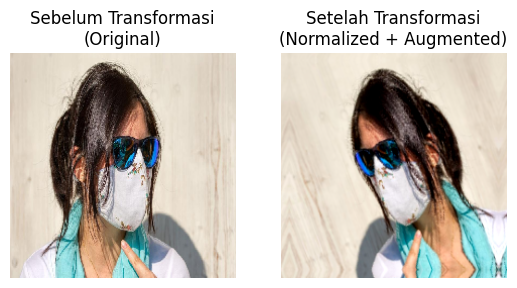

In [20]:
plt.subplot(1, 2, 1)
plt.imshow(img_before)
plt.title('Sebelum Transformasi\n(Original)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_augmented[0])
plt.title('Setelah Transformasi\n(Normalized + Augmented)')
plt.axis('off')

In [21]:
plt.tight_layout()
plt.show()
model = keras.Sequential([
    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Block 4
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten dan Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

<Figure size 640x480 with 0 Axes>

In [22]:
model.summary()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,600,385 (9.92 MB)

 Trainable params: 2,600,385 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [25]:
epochs = 20
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping, model_checkpoint]
)
plt.figure(figsize=(12, 4))

Epoch 1/20


2026-02-06 16:52:38.691499: I external/local_xla/xla/service/service.cc:163] XLA service 0x7a28c0002650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-06 16:52:38.691561: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2026-02-06 16:52:38.737234: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-06 16:52:39.008704: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91900
2026-02-06 16:52:39.081166: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-06 16:52:39.

  4/241 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.5775 - loss: 0.7386

I0000 00:00:1770371565.620598   86229 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8109 - loss: 0.4282
Epoch 1: val_accuracy improved from None to 0.91641, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 28s 82ms/step - accuracy: 0.8667 - loss: 0.3314 - val_accuracy: 0.9164 - val_loss: 0.2197
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9140 - loss: 0.2432
Epoch 2: val_accuracy improved from 0.91641 to 0.91796, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.9112 - loss: 0.2474 - val_accuracy: 0.9180 - val_loss: 0.2079
Epoch 3/20
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9113 - loss: 0.2447
Epoch 3: val_accuracy did not improve from 0.91796
241/241 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.9134 - loss: 0.2346 - val_accuracy: 0.9133 - val_loss: 0.2613
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9160 - loss: 0.2381
Epoch 4: val_accuracy improved from 0.91796 to 0.92471, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.9181 - loss: 0.2261 - val_accuracy: 0.9247 - val_loss: 0.1899
Epoch 5/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9131 - loss: 0.2251
Epoch 5: val_accuracy improved from 0.92471 to 0.92731, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.9129 - loss: 0.2282 - val_accuracy: 0.9273 - val_loss: 0.1896
Epoch 6/20
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9192 - loss: 0.2162
Epoch 6: val_accuracy did not improve from 0.92731
241/241 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.9163 - loss: 0.2180 - val_accuracy: 0.9216 - val_loss: 0.2011
Epoch 7/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9181 - loss: 0.2167
Epoch 7: val_accuracy improved from 0.92731 to 0.92887, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.9192 - loss: 0.2116 - val_accuracy: 0.9289 - val_loss: 0.1868
Epoch 8/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9220 - loss: 0.2125
Epoch 8: val_accuracy improved from 0.92887 to 0.93198, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.9225 - loss: 0.2018 - val_accuracy: 0.9320 - val_loss: 0.1764
Epoch 9/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9267 - loss: 0.2096
Epoch 9: val_accuracy improved from 0.93198 to 0.93510, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.9234 - loss: 0.2033 - val_accuracy: 0.9351 - val_loss: 0.1717
Epoch 10/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9277 - loss: 0.2035
Epoch 10: val_accuracy did not improve from 0.93510
241/241 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.9268 - loss: 0.2004 - val_accuracy: 0.9283 - val_loss: 0.1906
Epoch 11/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9262 - loss: 0.1974
Epoch 11: val_accuracy did not improve from 0.93510
241/241 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.9238 - loss: 0.1983 - val_accuracy: 0.9325 - val_loss: 0.1782
Epoch 12/20
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9237 - loss: 0.2048
Epoch 12: val_accuracy improved from 0.93510 to 0.93769, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.9263 - loss: 0.1970 - val_accuracy: 0.9377 - val_loss: 0.1646
Epoch 13/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9309 - loss: 0.1822
Epoch 13: val_accuracy improved from 0.93769 to 0.93873, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.9288 - loss: 0.1869 - val_accuracy: 0.9387 - val_loss: 0.1705
Epoch 14/20
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9282 - loss: 0.1847
Epoch 14: val_accuracy did not improve from 0.93873
241/241 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.9272 - loss: 0.1842 - val_accuracy: 0.9341 - val_loss: 0.1729
Epoch 15/20
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9288 - loss: 0.1836
Epoch 15: val_accuracy did not improve from 0.93873
241/241 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.9292 - loss: 0.1820 - val_accuracy: 0.9351 - val_loss: 0.1717
Epoch 16/20
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9327 - loss: 0.1780
Epoch 16: val_accuracy did not improve from 0.93873
241/241 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.9318 - loss: 0.1797 - val_accuracy: 0.9325 - val_loss: 0.1961
Epoch 17/20
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9368 - loss: 0.1766
Epoch 17: val_ac

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

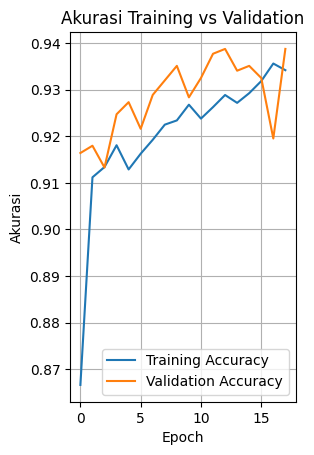

In [26]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

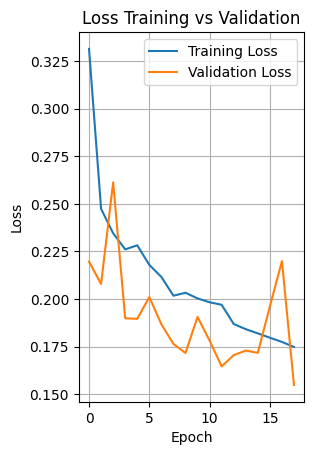

In [27]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [28]:
plt.tight_layout()
plt.show()
# Evaluasi model pada validation dataset
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_accuracy:.2%}")
print(f"Validation Loss: {val_loss:.4f}")

<Figure size 640x480 with 0 Axes>

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9387 - loss: 0.1705
Validation Accuracy: 93.87%
Validation Loss: 0.1705


In [29]:
# Prediksi untuk confusion matrix
val_predictions = model.predict(val_dataset)
val_predictions_binary = (val_predictions > 0.5).astype(int).flatten()

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [30]:
# Ambil label asli dari validation dataset
val_labels = []
for images, labels in val_dataset:
    val_labels.extend(labels.numpy())
val_labels = np.array(val_labels)

2026-02-06 16:56:57.002182: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [31]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(val_labels, val_predictions_binary)

In [32]:
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(val_labels, val_predictions_binary, target_names=class_names))


Confusion Matrix:
[[906  49]
 [ 69 902]]

Classification Report:
              precision    recall  f1-score   support

   with_mask       0.93      0.95      0.94       955
without_mask       0.95      0.93      0.94       971

    accuracy                           0.94      1926
   macro avg       0.94      0.94      0.94      1926
weighted avg       0.94      0.94      0.94      1926



In [33]:
plt.tight_layout()
plt.show()
# Load semua file test
test_files = sorted(glob.glob(os.path.join(test_dir, '*.jpg')))
print(f"Total test images: {len(test_files)}")

<Figure size 640x480 with 0 Axes>

Total test images: 371


In [34]:
# Prediksi untuk setiap file test
predictions = []
filenames = []

In [35]:
for test_file in test_files:
    # Load dan preprocess image
    img = keras.preprocessing.image.load_img(test_file, target_size=img_size, color_mode='rgb')
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    pred = model.predict(img_array, verbose=0)[0][0]
    pred_binary = 1 if pred > 0.5 else 0

    # Simpan hasil
    filename = os.path.basename(test_file)
    filenames.append(filename)
    predictions.append(pred_binary)

In [36]:
print(f"Prediksi selesai untuk {len(predictions)} gambar")
# Buat submission file
submission_df = pd.DataFrame({
    'filename': filenames,
    'label': predictions
})

Prediksi selesai untuk 371 gambar


In [37]:
# Simpan ke CSV
submission_df.to_csv('submission.csv', index=False)
print("\nSubmission file saved as 'submission.csv'")
print(f"\nPreview submission:")
print(submission_df.head(10))
print(f"\nDistribusi prediksi:")
print(f"Class 0 (with_mask): {(submission_df['label'] == 0).sum()}")
print(f"Class 1 (without_mask): {(submission_df['label'] == 1).sum()}")


Submission file saved as 'submission.csv'

Preview submission:
           filename  label
0  test_2000000.jpg      0
1  test_2000002.jpg      0
2  test_2000006.jpg      0
3  test_2000008.jpg      1
4  test_2000009.jpg      1
5  test_2000011.jpg      0
6  test_2000012.jpg      0
7  test_2000015.jpg      1
8  test_2000019.jpg      0
9  test_2000021.jpg      1

Distribusi prediksi:
Class 0 (with_mask): 201
Class 1 (without_mask): 170
